### **Key Findings from Feature Importance:**

In the Random Forest model, the top 5 features accounted for 58.42% of the total importance. These features provide valuable insight into customer behavior:

**Average Transaction Amount and Total Spend** were the top drivers, indicating that higher spending customers are less likely to churn.

**Annual Income and Age** also played significant roles, suggesting that customer demographics are linked to churn risk.

**Customer Loyalty** reflects the importance of a long-term relationship in reducing churn.

------
In contrast, the XGBoost model’s top 5 features explained only 29.96% of the total importance, showing that it relied on a more distributed set of factors:

**Recency** was the top predictor, with recent customers being less likely to churn.

**Gender** emerged as a key demographic factor.

**Average Transaction Amount** was important here as well but less dominant than in Random Forest.

**Number of Support Contacts** indicates that frequent interactions with support might signal dissatisfaction, leading to churn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/content/online_retail_customer_churn.csv')
data.head()

,Customer_ID,Age,Gender,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In,Promotion_Response,Target_Churn
0,1,62,Other,45.15,5892.58,5,22,453.80,2,0,3,129,True,Responded,True
1,2,65,Male,79.51,9025.47,13,77,22.90,2,2,3,227,False,Responded,False
2,3,18,Male,29.19,618.83,13,71,50.53,5,2,2,283,False,Responded,True
3,4,21,Other,79.63,9110.30,3,33,411.83,5,3,5,226,True,Ignored,True
4,5,21,Other,77.66,5390.88,15,43,101.19,3,0,5,242,False,Unsubscribed,False


In [3]:
# Checking for missing values
data.isnull().sum()

,0
Customer_ID,0
Age,0
Gender,0
Annual_Income,0
Total_Spend,0
Years_as_Customer,0
Num_of_Purchases,0
Average_Transaction_Amount,0
Num_of_Returns,0
Num_of_Support_Contacts,0


In [4]:
data.describe()

,Customer_ID,Age,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,43.267000,111.962960,5080.79265,9.727000,49.456000,266.876530,4.612000,1.934000,2.974000,182.890000
std,288.819436,15.242311,52.844111,2862.12335,5.536346,28.543595,145.873445,2.896869,1.402716,1.391855,104.391319
min,1.000000,18.000000,20.010000,108.94000,1.000000,1.000000,10.460000,0.000000,0.000000,1.000000,1.000000
25%,250.750000,30.000000,67.800000,2678.67500,5.000000,25.000000,139.682500,2.000000,1.000000,2.000000,93.000000
50%,500.500000,43.000000,114.140000,4986.19500,9.000000,49.000000,270.100000,5.000000,2.000000,3.000000,180.500000
75%,750.250000,56.000000,158.452500,7606.47000,14.000000,74.000000,401.602500,7.000000,3.000000,4.000000,274.000000
max,1000.000000,69.000000,199.730000,9999.64000,19.000000,99.000000,499.570000,9.000000,4.000000,5.000000,364.000000


In [5]:
# Distribution of churn vs non-churn customers
data['Target_Churn'].value_counts()

,count
Target_Churn,
True,526
False,474


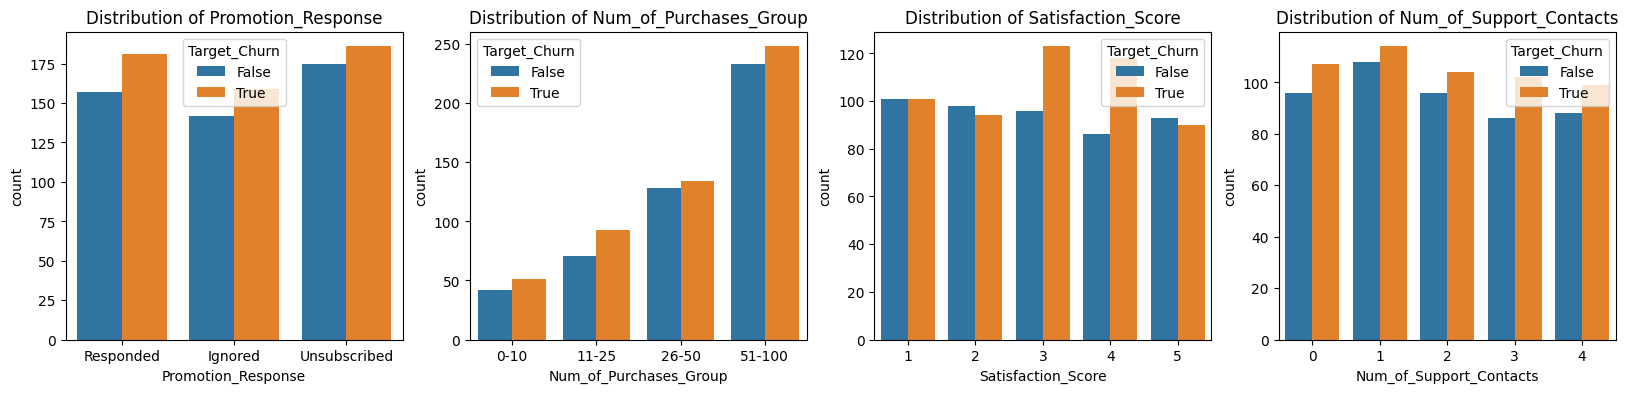


--------------------------------------------------
Churn rate for each categorical feature:
Churn rate by Promotion_Response:
  Promotion_Response  Churn_Rate (%)
0            Ignored       52.823920
1          Responded       53.550296
2       Unsubscribed       51.523546

Churn rate by Num_of_Purchases_Group:
  Num_of_Purchases_Group  Churn_Rate (%)
0                   0-10       54.838710
1                  11-25       56.707317
2                  26-50       51.145038
3                 51-100       51.559252

Churn rate by Satisfaction_Score:
   Satisfaction_Score  Churn_Rate (%)
0                   1       50.000000
1                   2       48.958333
2                   3       56.164384
3                   4       57.843137
4                   5       49.180328

Churn rate by Num_of_Support_Contacts:
   Num_of_Support_Contacts  Churn_Rate (%)
0                        0       52.709360
1                        1       51.351351
2                        2       52.000000
3     

In [6]:
data['Num_of_Purchases_Group'] = pd.cut(data['Num_of_Purchases'], bins=[0, 10, 25, 50, 100], labels=['0-10', '11-25', '26-50', '51-100'])

# Explore categorical features
cat_features = ["Promotion_Response", "Num_of_Purchases_Group", "Satisfaction_Score", "Num_of_Support_Contacts"]

# Countplot for categorical features
fig, axes = plt.subplots(1, len(cat_features), figsize=(20, 4))
for i, feature in enumerate(cat_features):
    sns.countplot(x=feature, hue='Target_Churn', data=data, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
plt.show()

print('\n--------------------------------------------------')
# Calculate churn rate for each categorical feature
print('Churn rate for each categorical feature:')
for feature in cat_features:
    churn_rate = data.groupby(feature)['Target_Churn'].mean() * 100
    churn_rate_df = churn_rate.reset_index().rename(columns={'Target_Churn': 'Churn_Rate (%)'})
    print(f"Churn rate by {feature}:\n{churn_rate_df}\n")

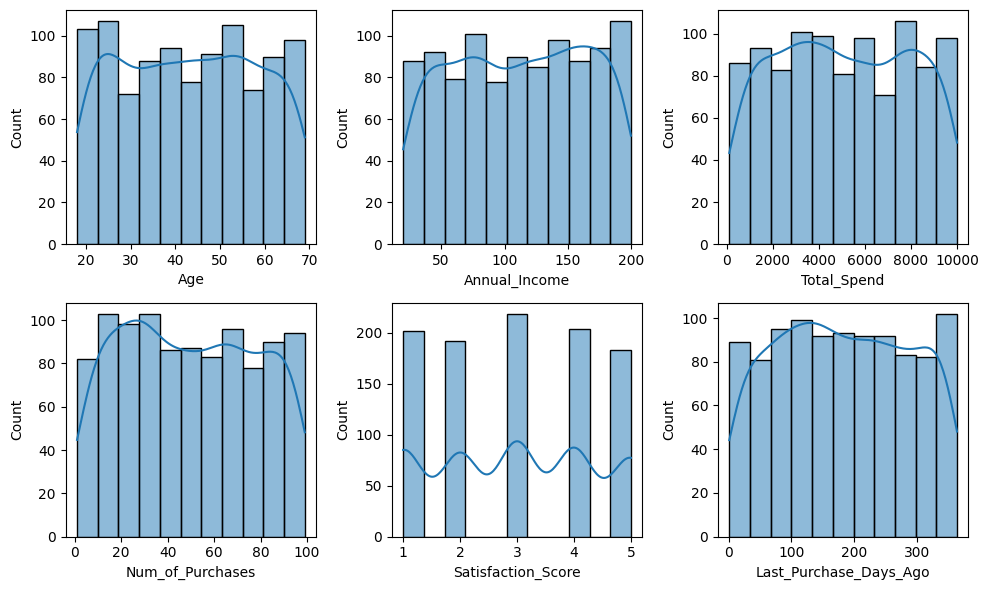

In [7]:
# Visualizing numerical variables
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
sns.histplot(data['Age'], ax=axes[0, 0], kde=True)
sns.histplot(data['Annual_Income'], ax=axes[0, 1], kde=True)
sns.histplot(data['Total_Spend'], ax=axes[0, 2], kde=True)
sns.histplot(data['Num_of_Purchases'], ax=axes[1, 0], kde=True)
sns.histplot(data['Satisfaction_Score'], ax=axes[1, 1], kde=True)
sns.histplot(data['Last_Purchase_Days_Ago'], ax=axes[1, 2], kde=True)
plt.tight_layout()
plt.show()

# **Feature Engineering**

Some new features will be created from existing ones:

**Customer Loyalty**: A combination of years as a customer and satisfaction score.

**Recency**: Using Last_Purchase_Days_Ago to categorize customers by how recently they purchased.

**High Value Customer**: Customers with high total spend.

In [8]:
# Customer Loyalty: satisfaction multiplied by years as a customer
data['Customer_Loyalty'] = data['Satisfaction_Score'] * data['Years_as_Customer']

# Recency categories: Binning Last_Purchase_Days_Ago
bins = [0, 30, 90, 180, 365]
labels = ['Very Recent', 'Recent', 'Moderate', 'Not Recent']
data['Recency_Category'] = pd.cut(data['Last_Purchase_Days_Ago'], bins=bins, labels=labels)

# High Value Customer flag based on total spend threshold
data['High_Value_Customer'] = np.where(data['Total_Spend'] > 8000, 1, 0)

In [9]:
# Convert categorical variables to dummy variables
data = pd.get_dummies(data, columns=['Gender', 'Promotion_Response', 'Recency_Category', 'Num_of_Purchases_Group'], drop_first=True)

In [10]:
# Scaling the continuous features
scaler = StandardScaler()

continuous_features = ['Age', 'Annual_Income', 'Total_Spend', 'Average_Transaction_Amount', 'Years_as_Customer',
                       'Num_of_Returns', 'Num_of_Support_Contacts', 'Satisfaction_Score']
data[continuous_features] = scaler.fit_transform(data[continuous_features])

# **Model Building**

In [11]:
# Features and target variable
# Remove Num_of_Purchases & Last_Purchase_Days_Ago because we already created their respective categorical variables above
X = data.drop(['Customer_ID', 'Target_Churn', 'Num_of_Purchases', 'Last_Purchase_Days_Ago'], axis=1)
y = data['Target_Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### We’ll use three models for comparison: Logistic Regression, Random Forest Classifier, and XGBoost Classifier.

### **Logistic Regression**

In [12]:
# Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict
y_pred_logreg = log_reg.predict(X_test)

### **Random Forest Classifier**

In [13]:
# Hyperparameter Tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid,
                                      n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random_search.fit(X_train, y_train)
print("Best parameters for Random Forest:", rf_random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}


In [14]:
# Train models with best parameters
rf_clf = RandomForestClassifier(**rf_random_search.best_params_, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict
y_pred_rf = rf_clf.predict(X_test)

### **XGBoost Classifier**

In [15]:
# Hyperparameter Tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5]
}

xgb_model = XGBClassifier(random_state=42)
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_grid,
                                       n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
xgb_random_search.fit(X_train, y_train)
print("Best parameters for XGBoost:", xgb_random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters for XGBoost: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}


In [16]:
# Train models with best parameters
xgb_clf = XGBClassifier(**xgb_random_search.best_params_, random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_clf.predict(X_test)

# **Model Evaluation**

In [17]:
# Evaluation - Logistic Regression
print("Logistic Regression Model Evaluation:")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print('-'*50)
# Evaluation - Random Forest
print("Random Forest Model Evaluation:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print('-'*50)
# Evaluation - XGBoost
print("XGBoost Model Evaluation:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

Logistic Regression Model Evaluation:
[[52 83]
 [76 89]]
              precision    recall  f1-score   support

       False       0.41      0.39      0.40       135
        True       0.52      0.54      0.53       165

    accuracy                           0.47       300
   macro avg       0.46      0.46      0.46       300
weighted avg       0.47      0.47      0.47       300

Accuracy: 0.47
--------------------------------------------------
Random Forest Model Evaluation:
[[ 49  86]
 [ 62 103]]
              precision    recall  f1-score   support

       False       0.44      0.36      0.40       135
        True       0.54      0.62      0.58       165

    accuracy                           0.51       300
   macro avg       0.49      0.49      0.49       300
weighted avg       0.50      0.51      0.50       300

Accuracy: 0.5066666666666667
--------------------------------------------------
XGBoost Model Evaluation:
[[50 85]
 [71 94]]
              precision    recall  f1-score

# **Feature Importance**

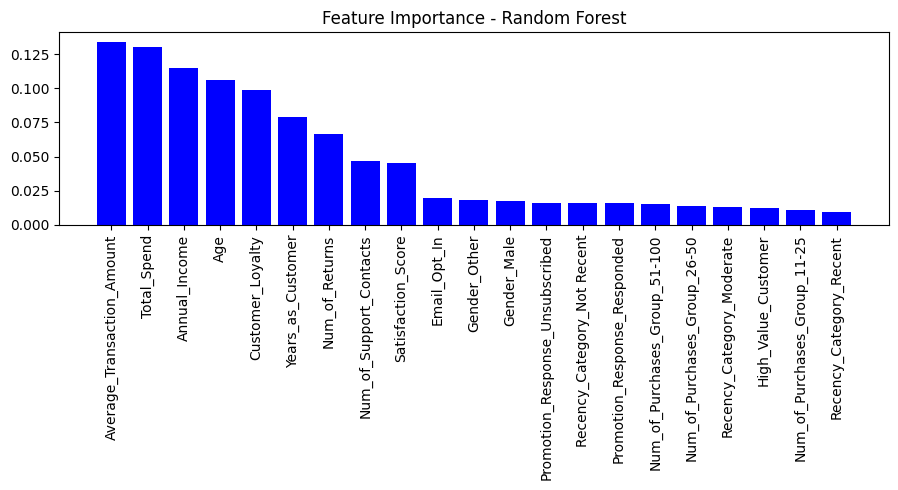

Top 5 feature importances in Random Forest model:
                                   0
Average_Transaction_Amount  0.134226
Total_Spend                 0.130203
Annual_Income               0.115193
Age                         0.105807
Customer_Loyalty            0.098815
The sum of the top 5 feature importances is: 58.42%


In [18]:
# Feature Importance Analysis for Random Forest
importances_rf = rf_clf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
features_rf = X.columns

plt.figure(figsize=(9, 5))
plt.title("Feature Importance - Random Forest")
plt.bar(range(X.shape[1]), importances_rf[indices_rf], color='b', align='center')
plt.xticks(range(X.shape[1]), features_rf[indices_rf], rotation=90)
plt.tight_layout()
plt.show()

fi_rf = pd.DataFrame(importances_rf[indices_rf],features_rf[indices_rf]).head(5)
print('Top 5 feature importances in Random Forest model:')
print(fi_rf)
print(f"The sum of the top 5 feature importances is: {round(np.sum(fi_rf[0])*100,2)}%")

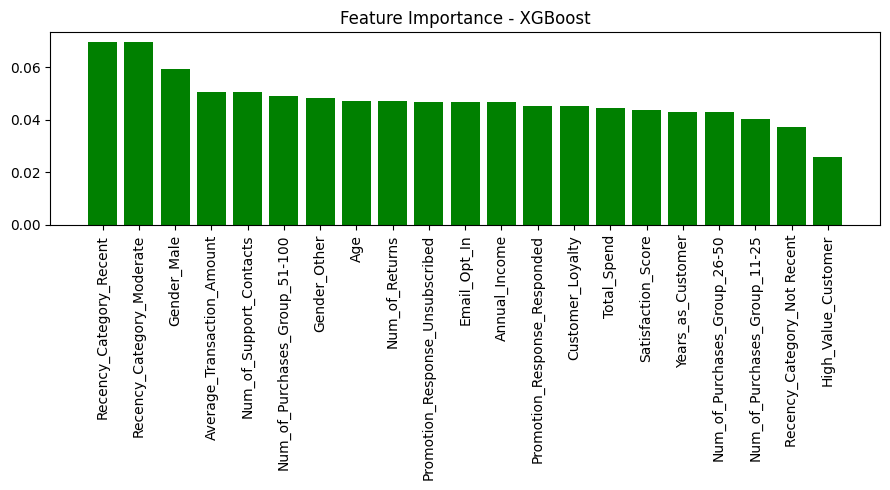

Top 5 feature importances in XGBoost model:
                                   0
Recency_Category_Recent     0.069760
Recency_Category_Moderate   0.069522
Gender_Male                 0.059250
Average_Transaction_Amount  0.050660
Num_of_Support_Contacts     0.050458
The sum of the top 5 feature importances is: 29.96%


In [19]:
# Feature Importance Analysis for XGBoost
importances_xgb = xgb_clf.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
features_xgb = X.columns

plt.figure(figsize=(9, 5))
plt.title("Feature Importance - XGBoost")
plt.bar(range(X.shape[1]), importances_xgb[indices_xgb], color='g', align='center')
plt.xticks(range(X.shape[1]), features_xgb[indices_xgb], rotation=90)
plt.tight_layout()
plt.show()

fi_xgb = pd.DataFrame(importances_xgb[indices_xgb],features_xgb[indices_xgb]).head(5)
print('Top 5 feature importances in XGBoost model:')
print(fi_xgb)
print(f"The sum of the top 5 feature importances is: {round(np.sum(fi_xgb[0])*100,2)}%")

### **Key Findings from Feature Importance:**

In the Random Forest model, the top 5 features accounted for 58.42% of the total importance. These features provide valuable insight into customer behavior:

**Average Transaction Amount and Total Spend** were the top drivers, indicating that higher spending customers are less likely to churn.

**Annual Income and Age** also played significant roles, suggesting that customer demographics are linked to churn risk.

**Customer Loyalty** reflects the importance of a long-term relationship in reducing churn.

------
In contrast, the XGBoost model’s top 5 features explained only 29.96% of the total importance, showing that it relied on a more distributed set of factors:

**Recency** was the top predictor, with recent customers being less likely to churn.

**Gender** emerged as a key demographic factor.

**Average Transaction Amount** was important here as well but less dominant than in Random Forest.

**Number of Support Contacts** indicates that frequent interactions with support might signal dissatisfaction, leading to churn.